# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
3
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import jacobi_constant, calculate_errors_per_orbit
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, calculate_closest_feature_distances, find_nearest_orbits_batch, calculate_pairwise_distances
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids, interpolate_sample
from orbit_generation.convergence import process_diferential_correction_orbits

In [3]:
import numpy as np
import pandas as pd
import os
from pytorch_lightning import Trainer

# Parameters

In [4]:
want_to_train = True   # Set this parameter to False if you want to load the model from the folder
want_to_generate = True    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = True   # Set this parameter to False if you don't want to calculate any metric
want_to_get_cluster_metrics = True    # Set this parameter to False if you don't want to calculate clustering metrics
want_to_perform_convergence = True   # Set this parameter to False if you don't want to perform convergence

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 0.1,
    'lr': 0.001,
    'dropout_rate': 0.2,
    'samples_to_generate' : 100,
    'distance_metric' : 'euclidean',
    'max_iter_convergence' : 50
}

# Saving paths

In [7]:
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_13


In [8]:
# Images
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_orbits.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids.npy')

# Data

## Import

In [9]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [10]:
if params['feature_dim']==6:
    data=data[:,1:,:]
    data.shape

## Scaling

In [11]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [12]:
model = get_model(params)

In [13]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. T

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | encoder       | Conv5EncoderLegitTsgm | 3.4 M  | train
1 | decoder       | Conv5DecoderLegitTsgm | 3.4 M  | train
2 | sampling      | Sampling              | 0      | train
3 | train_metrics | MetricCollection      | 0      | train
4 | val_metrics   | MetricCollection      | 0      | train
----------------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.859    Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


val_total_loss: 5.556051731109619
val_reconstruction_loss: 4.994815349578857
val_kl_loss: 0.5612371563911438
train_total_loss: 2.925509214401245
train_reconstruction_loss: 2.2467305660247803
train_kl_loss: 0.6787779927253723


## Generate

In [14]:
if want_to_generate:
    # Generate the orbits
    generation = model.sample(params['samples_to_generate'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

torch.Size([100, 7, 100])

# Analysis of Generation

## Visualization

In [15]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(100, 6, 100)

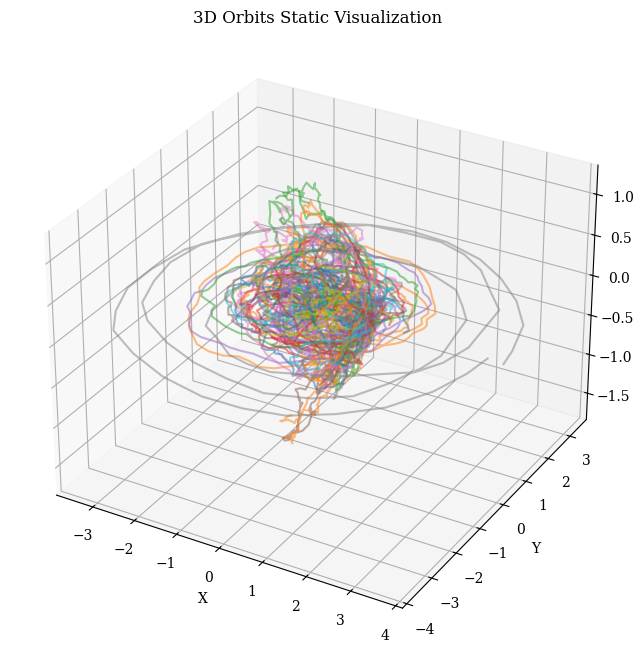

In [16]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

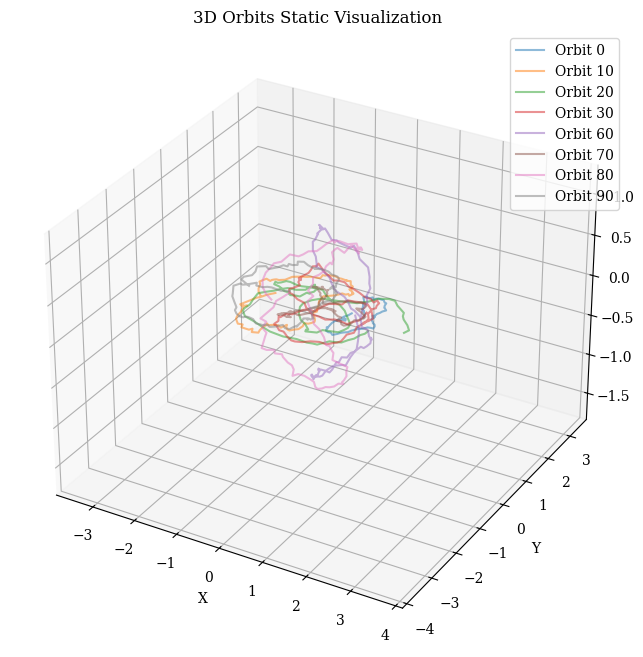

In [17]:
visualize_static_orbits(data= no_time_generation, orbit_indices=[0,10,20,30,60,70,80,90], save_path=static_some_orbit_path)

In [18]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_13/images/exp13_generated_orbits.html


## Coverage

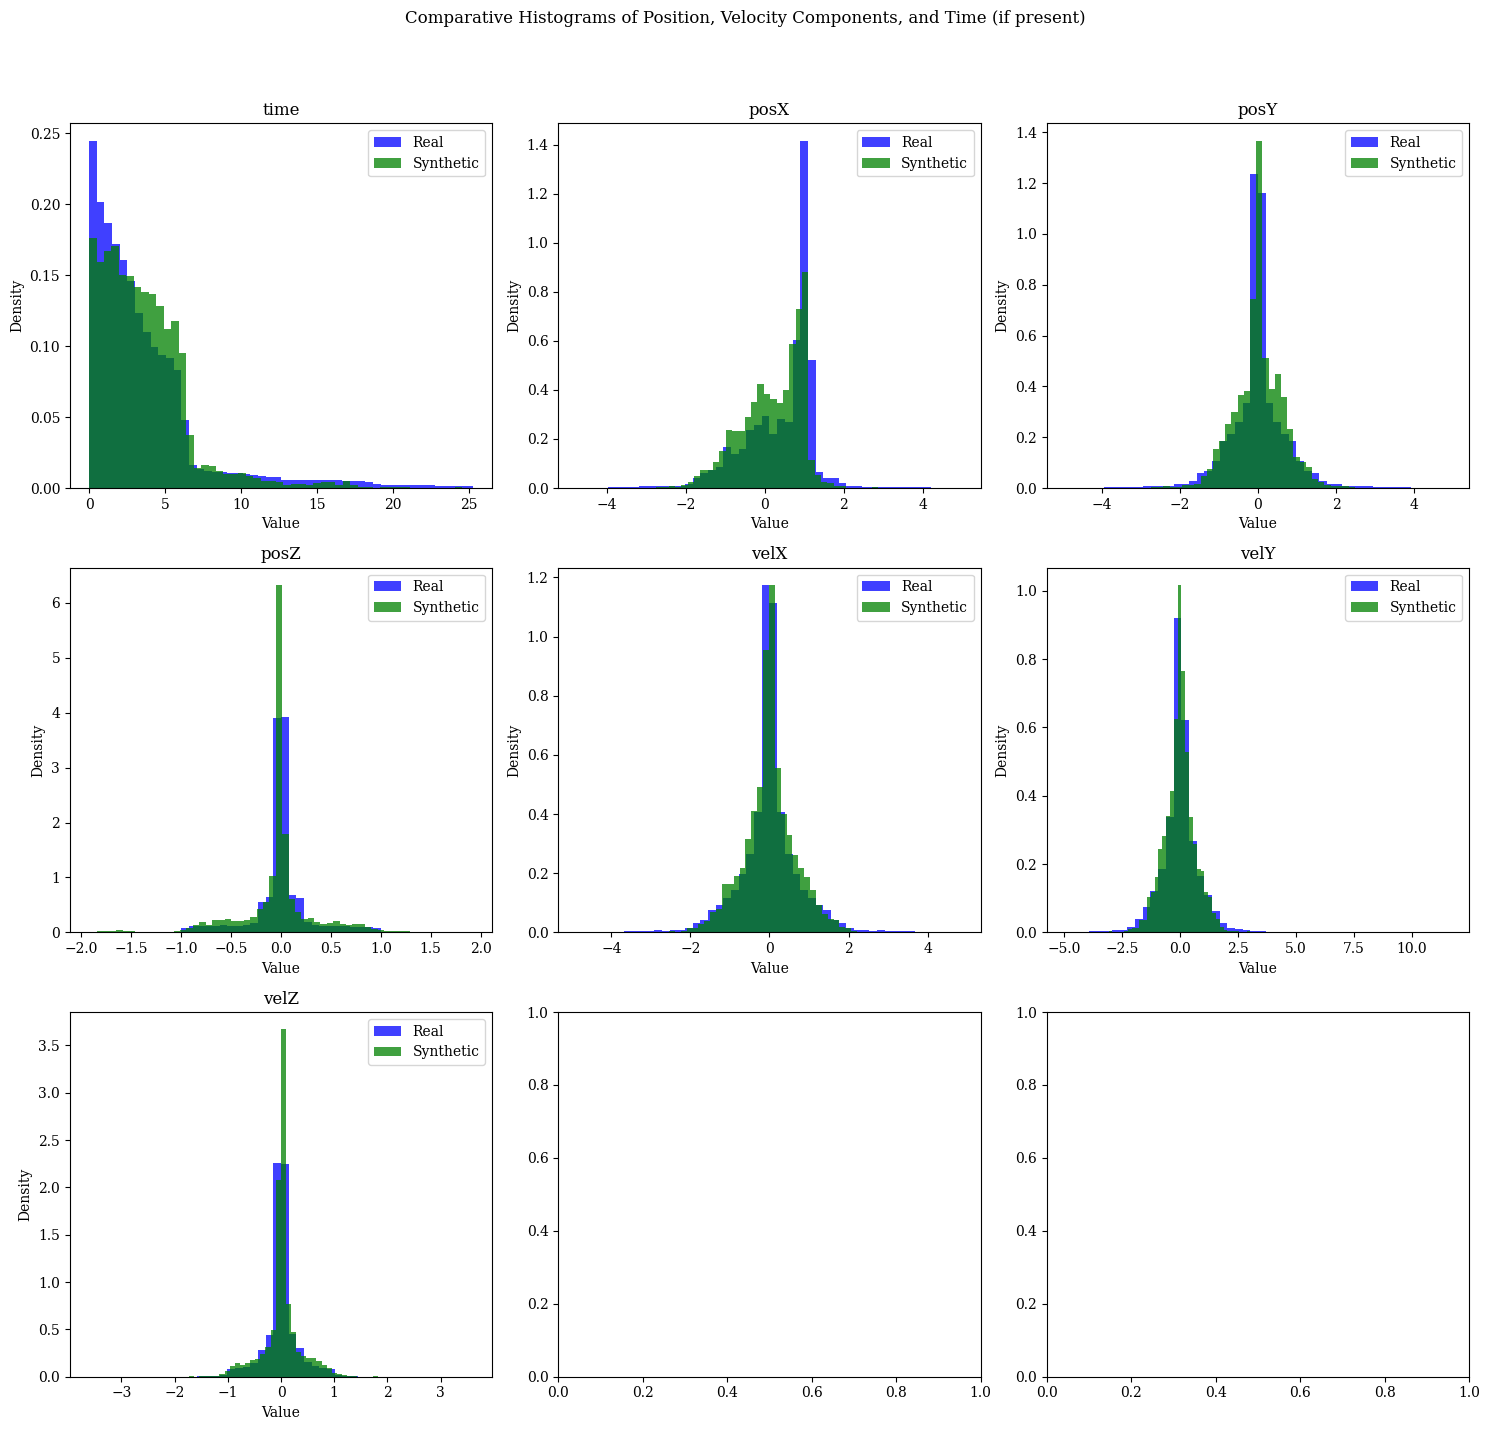

In [19]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

## Pheasibility

In [20]:

if calculate_error_metrics:
    reordered_orbits, order_metrics = reorder_orbits(generation)
    per_orbit_errors = calculate_errors_per_orbit(reordered_orbits,EM_MU)
    mean_errors = {key: np.mean(value) for key, value in per_orbit_errors.items()}
    add_experiment_metrics(experiments_folder, params=params, metrics={**mean_errors, **order_metrics})

Metrics added to experiment with ID 13 in ../experiments/experiments.json.


# Latent Space

In [21]:
latent_means, latent_log_vars = model.encode(scaled_data)
latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

(45211, 4)

In [22]:
orbits_id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
family_labels=get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

In [23]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroids_representation.shape

(40, 4)

In [24]:
unique_classes = list(set(orbits_id_classes))
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

40

## Visualize

Dataset

Saved plot to ../experiments/experiment_13/images/exp13_latent_space


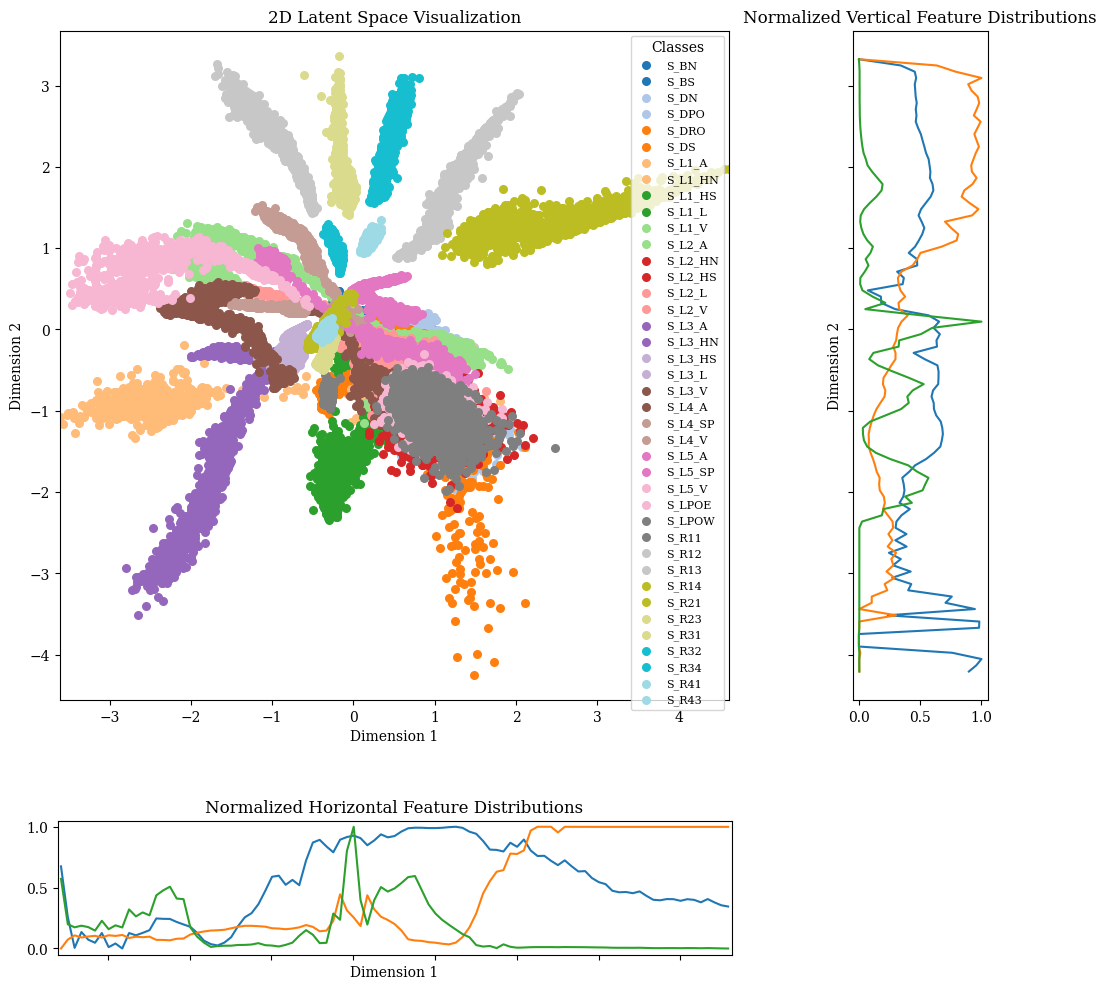

In [25]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(latent_means,
                            np.array(family_labels),
                            save_path=latent_space_path,
                            features=features,
                            feature_names=feature_names)
else:
    rls=reduce_dimensions_latent_space(latent_means,
                                        np.array(family_labels),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=latent_space_path,
                                        show_legend=False)

Centroids

Saved plot to ../experiments/experiment_13/images/exp13_family_centroids


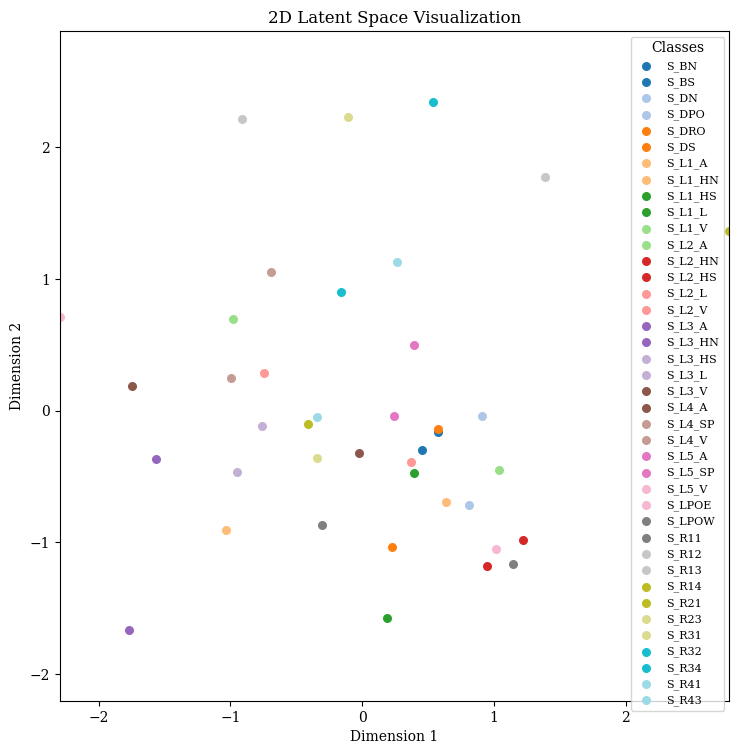

In [26]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(centroid_means,
                            np.array(family_names),
                            save_path=family_centroids_plot_path)
else:
    rls=reduce_dimensions_latent_space(centroid_means,
                                        np.array(family_names),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=family_centroids_plot_path,
                                        show_legend=False)

## Clustering

In [27]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_means, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

Metrics added to experiment with ID 13 in ../experiments/experiments.json.


# Convergence

In [28]:
if want_to_perform_convergence:
    refined_orbits, refined_orbits_df= process_diferential_correction_orbits(np.transpose(generation,(0,2,1)),
                                                                        EM_MU,
                                                                        max_iter=params['max_iter_convergence'])
    refined_orbits = np.transpose(refined_orbits,(0,2,1))
    np.save(refined_data_path, refined_orbits)
else:
    refined_orbits = np.load(refined_data_path)

refined_orbits.shape

INFO:orbit_generation.convergence:Processing orbit 1/100
INFO:orbit_generation.convergence:Orbit 0: Success=-1, Norm=11.215612719713414, Iterations=6
INFO:orbit_generation.convergence:Processing orbit 2/100
INFO:orbit_generation.convergence:Orbit 1: Success=-1, Norm=10.30334162110522, Iterations=4
INFO:orbit_generation.convergence:Processing orbit 3/100
INFO:orbit_generation.convergence:Orbit 2: Success=-1, Norm=10.044715030276883, Iterations=2
INFO:orbit_generation.convergence:Processing orbit 4/100
INFO:orbit_generation.convergence:Orbit 3: Success=-1, Norm=10.621263463658433, Iterations=6
INFO:orbit_generation.convergence:Processing orbit 5/100
INFO:orbit_generation.convergence:Orbit 4: Success=-1, Norm=13.707796880923508, Iterations=5
INFO:orbit_generation.convergence:Processing orbit 6/100
INFO:orbit_generation.convergence:Orbit 5: Success=-1, Norm=10.675737647488772, Iterations=13
INFO:orbit_generation.convergence:Processing orbit 7/100
INFO:orbit_generation.convergence:Orbit 6: 

(44, 7, 100)

In [29]:
generation_df = pd.DataFrame(per_orbit_errors)
generation_df.head()

,position_error,velocity_error,energy_error
0,0.119005,0.202918,2.682735
1,0.395450,0.425933,0.583399
2,0.129952,0.331835,1.194872
3,0.056560,0.187770,0.147265
4,0.458648,0.548438,4.756591


In [30]:
refined_orbits_df.head()

,id,old_period,new_period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0
0,7,7.035061,6.298454,9,3.689412e-11,0.898835,0.165559,0.005632,-0.072481,-1.265697,-0.191463,0.896844,0.238899,5.746924e-02,0.414903,-1.824975,-4.444494e-01
1,9,6.247465,6.229006,9,9.493773e-13,0.686075,-0.056299,0.058327,0.097942,0.236292,-0.282069,0.426547,-0.355852,1.697259e-01,0.637510,0.357546,-8.633163e-01
2,10,6.462869,6.239146,28,1.111117e-12,-1.484628,-0.095130,-0.082760,-0.109731,1.329157,0.083657,-1.691671,0.115665,-2.210234e-02,0.109524,1.273701,4.152033e-04
3,12,6.439878,5.035275,7,3.698309e-13,0.784022,0.047794,-0.006157,-0.024155,0.612464,0.051743,0.692427,0.196949,1.726545e-15,0.070610,0.651895,-3.752079e-15
4,17,6.230849,6.420801,9,6.785509e-10,0.475177,1.600130,-0.029435,1.010664,-0.559443,0.042832,0.571356,1.384470,-1.208457e-09,0.797616,-0.506436,6.197006e-10


In [31]:
refined_ids = refined_orbits_df['id'].astype(int).tolist()
generated_data_that_was_refined = generation[refined_ids]
generated_data_that_was_refined.shape

(44, 7, 100)

Generation that was able to get Refined

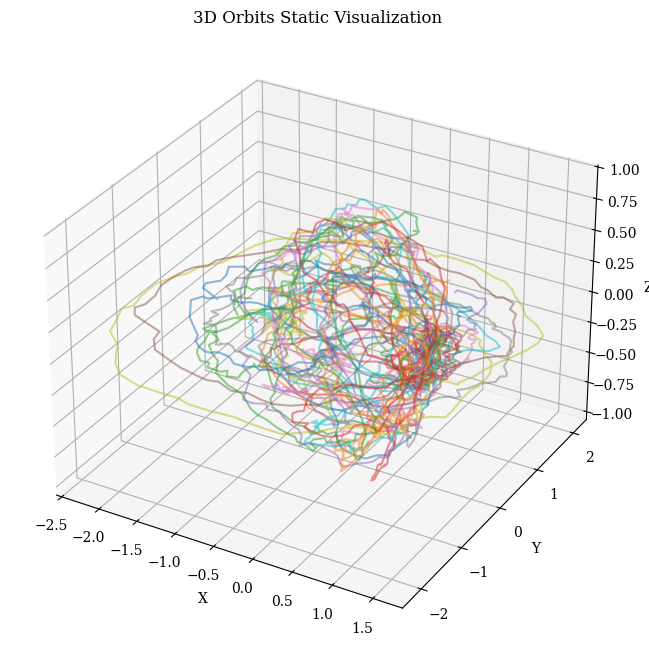

In [32]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path)

Refinement

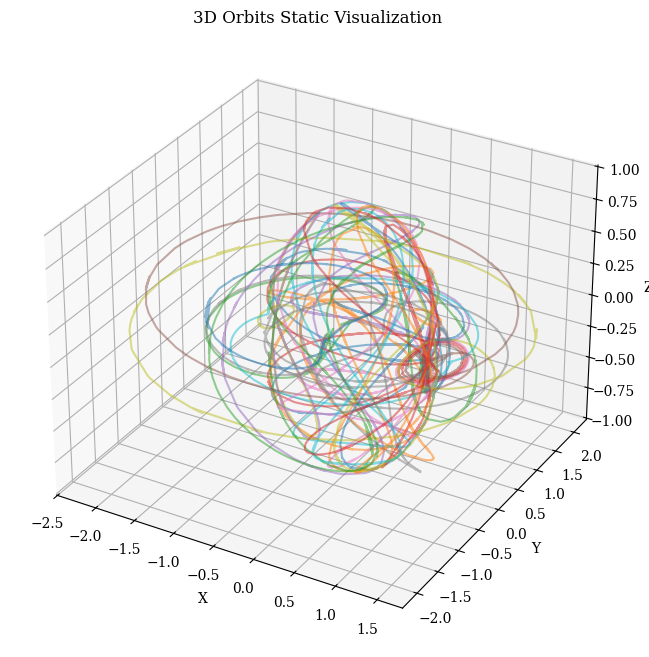

In [33]:
visualize_static_orbits(refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

Generation that didn't manage to get refined

In [34]:
non_refined_ids = sorted(set(range(params['samples_to_generate'])) - set(refined_ids))
generated_data_that_was_not_refined = generation[non_refined_ids]
generated_data_that_was_not_refined.shape

(56, 7, 100)

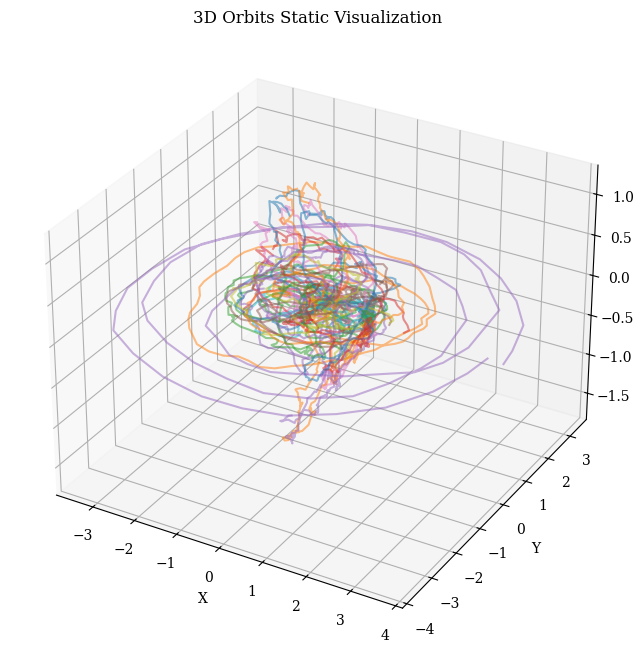

In [35]:
visualize_static_orbits(generated_data_that_was_not_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_did_not_converged_path)

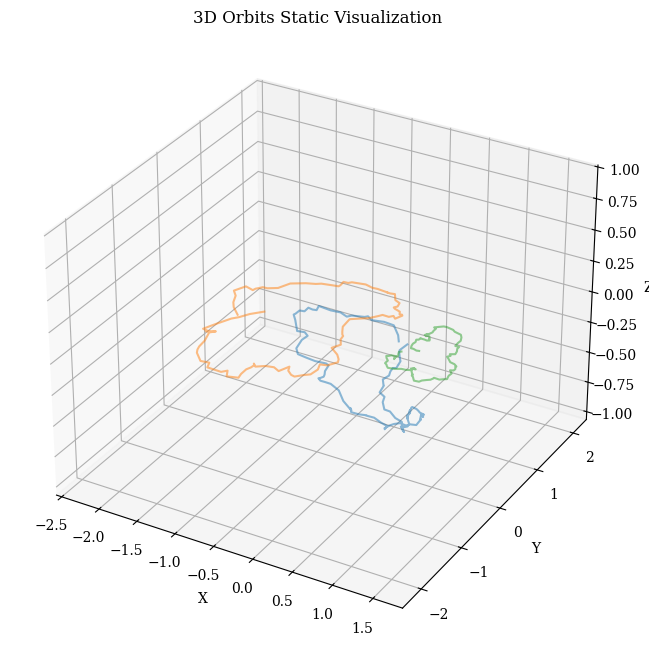

In [46]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path, orbit_indices=[1,2,3])

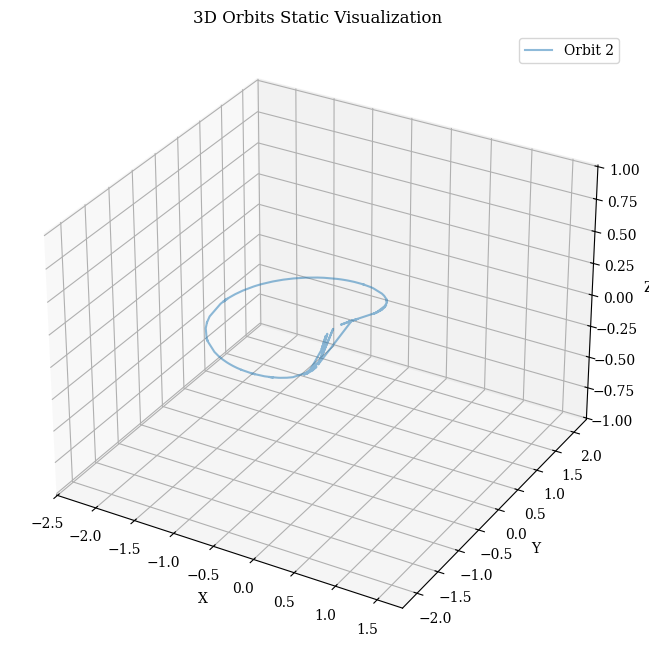

In [50]:
visualize_static_orbits(refined_orbits[:,1:,:], show_legend=True, save_path=refined_orbits_path, orbit_indices=[2])

## Latent Space

In [36]:
refined_scaled_data = scaler.transform(torch.from_numpy(refined_orbits).float())
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_representations = refined_latent_means.detach().numpy()
refined_latent_representations.shape

(44, 2)

Saved plot to ../experiments/experiment_13/images/exp13_combined_latent_space


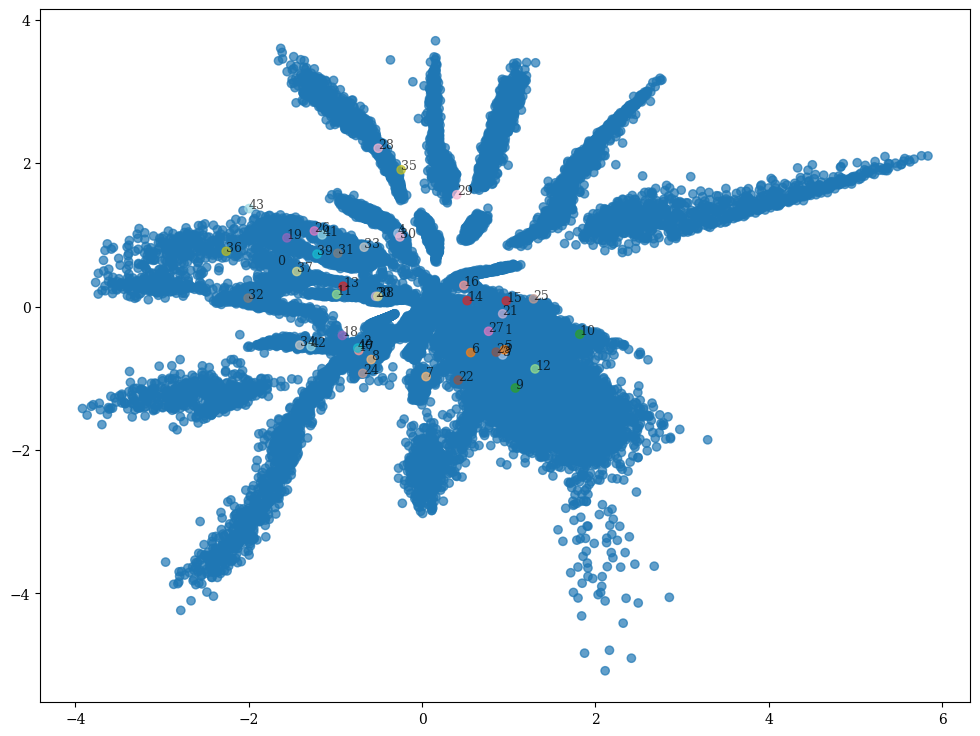

In [37]:
if refined_latent_representations.shape[1]>2:
    rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                        val_latent=refined_latent_representations)
    latent_representation=rls['PCA']['train']
    refined_latent_representations=rls['PCA']['val']

plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=refined_latent_representations,
    synthetic_labels=list(range(0, len(refined_scaled_data))),
    annotation_mode='numbers',
    save_path=combined_latent_space_path
)

In [38]:
### plot how far away we are from each convergence and generation in the latent space

## Check Novelty

Calculate Jacobi Constant on the dataset

In [39]:
results = np.array([jacobi_constant(np.transpose(data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(data.shape[0])])
orbit_df['calculated_jacobi'] = results

orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods,calculated_jacobi
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0,2.757415
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0,2.758229
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0,2.759042
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0,2.759853
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0,2.760663


Calculate Jacobi Constant and Period on the Refined Orbits

In [40]:
new_jacobis = np.array([jacobi_constant(np.transpose(refined_orbits[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(refined_orbits.shape[0])])
refined_orbits_df['calculated_jacobi'] = new_jacobis
refined_orbits_df.rename(columns={'new_period': 'period'}, inplace=True)
refined_orbits_df['period_distance_with_generation'] = abs(refined_orbits_df['period'] - refined_orbits_df['old_period'])
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,calculated_jacobi,period_distance_with_generation
0,7,7.035061,6.298454,9,3.689412e-11,0.898835,0.165559,0.005632,-0.072481,-1.265697,-0.191463,0.896844,0.238899,5.746924e-02,0.414903,-1.824975,-4.444494e-01,-0.635872,0.736607
1,9,6.247465,6.229006,9,9.493773e-13,0.686075,-0.056299,0.058327,0.097942,0.236292,-0.282069,0.426547,-0.355852,1.697259e-01,0.637510,0.357546,-8.633163e-01,2.426068,0.018459
2,10,6.462869,6.239146,28,1.111117e-12,-1.484628,-0.095130,-0.082760,-0.109731,1.329157,0.083657,-1.691671,0.115665,-2.210234e-02,0.109524,1.273701,4.152033e-04,2.435349,0.223723
3,12,6.439878,5.035275,7,3.698309e-13,0.784022,0.047794,-0.006157,-0.024155,0.612464,0.051743,0.692427,0.196949,1.726545e-15,0.070610,0.651895,-3.752079e-15,2.869307,1.404604
4,17,6.230849,6.420801,9,6.785509e-10,0.475177,1.600130,-0.029435,1.010664,-0.559443,0.042832,0.571356,1.384470,-1.208457e-09,0.797616,-0.506436,6.197006e-10,2.694368,0.189951


Compare Features between Dataset and Refinement

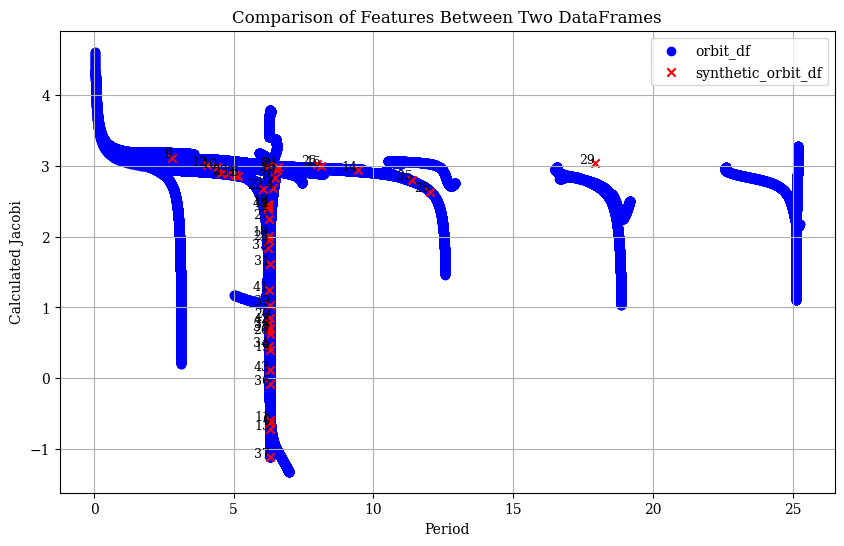

In [41]:
features = ['period', 'calculated_jacobi']

feature_distances = calculate_closest_feature_distances(orbit_df, refined_orbits_df, features)
refined_orbits_df['feature_distance_from_closest'] = feature_distances

## Calculate distances

In [42]:
if data.shape[1] == 7:
    no_time_data = data[:,1:,:]
    data.shape
else:
    no_time_data = data

no_time_data.shape

(45211, 6, 100)

In [43]:
if refined_orbits.shape[1] == 7:
    no_time_refined_orbits = refined_orbits[:,1:,:]
    generation.shape
else:
    no_time_refined_orbits = refined_orbits

no_time_refined_orbits.shape

(44, 6, 100)

In [44]:
no_time_generation.shape

(100, 6, 100)

In [67]:
import numpy as np

def euclidean_distance_pair(orbit1: np.ndarray, orbit2: np.ndarray) -> float:
    """
    Calculates the Euclidean distance between two orbits.
    
    :param orbit1: First orbit array (shape: [n_features, n_time_steps]).
    :param orbit2: Second orbit array (shape: [n_features, n_time_steps]).
    :return: Euclidean distance as a float.
    """
    return np.sqrt(np.sum((orbit1 - orbit2) ** 2))

def euclidean_distance_array(
    orbit_data1: np.ndarray,  # Shape: [n_samples1, n_features, n_time_steps]
    orbit_data2: np.ndarray   # Shape: [n_samples2, n_features, n_time_steps] or [n_features, n_time_steps]
) -> np.ndarray:
    """
    Calculates Euclidean distances between orbits in two datasets.
    
    If `orbit_data2` is a single orbit, computes the distance between each orbit in `orbit_data1` and `orbit_data2`.
    If both `orbit_data1` and `orbit_data2` contain multiple orbits, computes pairwise distances.
    
    :param orbit_data1: First set of orbits (shape: [n_samples1, n_features, n_time_steps]).
    :param orbit_data2: Second set of orbits or a single orbit.
                        Shape: [n_samples2, n_features, n_time_steps] or [n_features, n_time_steps].
    :return: NumPy array of distances.
             - If `orbit_data2` is a single orbit: Shape [n_samples1].
             - If both are datasets: Shape [n_samples1, n_samples2].
    """
    if orbit_data1.ndim != 3:
        raise ValueError(f"orbit_data1 must be a 3D array, got {orbit_data1.ndim}D array instead.")
    
    if orbit_data2.ndim == 2:
        # Single orbit case
        if orbit_data1.shape[1:] != orbit_data2.shape:
            raise ValueError("Feature and time step dimensions must match between orbit_data1 and orbit_data2.")
        
        # Vectorized computation
        differences = orbit_data1 - orbit_data2  # Broadcasting single orbit across orbit_data1
        squared_diff = differences ** 2
        sum_squared_diff = np.sum(squared_diff, axis=(1, 2))
        distances = np.sqrt(sum_squared_diff)
        
        return distances  # Shape: [n_samples1]
    
    elif orbit_data2.ndim == 3:
        # Pairwise comparison
        if orbit_data1.shape[1:] != orbit_data2.shape[1:]:
            raise ValueError("Feature and time step dimensions must match between orbit_data1 and orbit_data2.")
        
        # Reshape for broadcasting
        orbit_data1_exp = orbit_data1[:, np.newaxis, :, :]  # Shape: [n_samples1, 1, n_features, n_time_steps]
        orbit_data2_exp = orbit_data2[np.newaxis, :, :, :]  # Shape: [1, n_samples2, n_features, n_time_steps]
        
        differences = orbit_data1_exp - orbit_data2_exp  # Shape: [n_samples1, n_samples2, n_features, n_time_steps]
        squared_diff = differences ** 2
        sum_squared_diff = np.sum(squared_diff, axis=(2, 3))  # Sum over features and time steps
        distances = np.sqrt(sum_squared_diff)  # Shape: [n_samples1, n_samples2]
        
        return distances
    
    else:
        raise ValueError("orbit_data2 must be either a 2D or 3D array.")

In [70]:
def find_nearest_orbits(single_orbit: np.ndarray,
                        orbit_data: np.ndarray,
                        n: int,
                        distance_metric: str = 'euclidean') -> tuple:
    """
    Finds the n closest orbits in orbit_data to the single_orbit based on the specified distance metric.
    
    :param single_orbit: The reference orbit (shape: [n_features, n_time_steps]).
    :param orbit_data: The dataset of orbits (shape: [n_samples, n_features, n_time_steps]).
    :param n: The number of closest orbits to return.
    :param distance_metric: The distance metric to use ('euclidean', 'manhattan', 'cosine', 'dtw').
                            Defaults to 'euclidean'.
    :return: A tuple containing:
             - Indices of the n closest orbits in orbit_data.
             - Distances of the n closest orbits.
    """
    
    # Select the appropriate distance function
    if distance_metric == 'euclidean':
        distances = euclidean_distance_array(orbit_data, single_orbit)
    elif distance_metric == 'manhattan':
        distances = manhattan_distance_array(orbit_data, single_orbit)
    elif distance_metric == 'cosine':
        distances = cosine_distance_array(orbit_data, single_orbit)
    elif distance_metric == 'dtw':
        distances = dtw_distance_array(orbit_data, single_orbit)
    else:
        raise ValueError(f"Unsupported distance metric: {distance_metric}")
    
    # Get the indices of the n smallest distances
    nearest_indices = np.argsort(distances)[:n]
    
    # Get the corresponding distances
    nearest_distances = distances[nearest_indices]
    
    return nearest_indices, nearest_distances

In [71]:
def find_nearest_orbits_batch(
    single_orbits: np.ndarray,       # Shape: [num_single_orbits, n_features, n_time_steps]
    orbit_data: np.ndarray,          # Shape: [n_samples, n_features, n_time_steps]
    n: int,                           # Number of nearest orbits to find
    distance_metric: str = 'euclidean'  # Distance metric
) -> tuple:
    """
    Iteratively finds the n closest orbits in orbit_data for each orbit in single_orbits.

    :param single_orbits: The reference orbits (shape: [num_single_orbits, n_features, n_time_steps]).
    :param orbit_data: The dataset of orbits to search within (shape: [n_samples, n_features, n_time_steps]).
    :param n: The number of closest orbits to return for each single_orbit.
    :param distance_metric: The distance metric to use ('euclidean', 'manhattan', 'cosine', 'dtw').
                            Defaults to 'euclidean'.
    :return: A tuple containing:
             - A 2D array of shape [num_single_orbits, n] with indices of the n closest orbits.
             - A 2D array of shape [num_single_orbits, n] with distances of the n closest orbits.
    """
    
    # Validate input dimensions
    if single_orbits.ndim != 3:
        raise ValueError(f"single_orbits must be a 3D array, got {single_orbits.ndim}D array instead.")
    if orbit_data.ndim != 3:
        raise ValueError(f"orbit_data must be a 3D array, got {orbit_data.ndim}D array instead.")
    if single_orbits.shape[1:] != orbit_data.shape[1:]:
        raise ValueError("Each single_orbit must have the same shape as the orbits in orbit_data.")
    if n <= 0:
        raise ValueError("Parameter n must be a positive integer.")
    if distance_metric not in ['euclidean', 'manhattan', 'cosine', 'dtw']:
        raise ValueError(f"Unsupported distance metric: {distance_metric}. Choose from 'euclidean', 'manhattan', 'cosine', 'dtw'.")

    num_single_orbits = single_orbits.shape[0]
    
    nearest_indices_all = np.empty((num_single_orbits, n), dtype=int)
    nearest_distances_all = np.empty((num_single_orbits, n), dtype=float)

    for i in range(num_single_orbits):
        single_orbit = single_orbits[i]
        nearest_indices, nearest_distances = find_nearest_orbits(
            single_orbit=single_orbit,
            orbit_data=orbit_data,
            n=n,
            distance_metric=distance_metric
        )
        nearest_indices_all[i] = nearest_indices
        nearest_distances_all[i] = nearest_distances

    return nearest_indices_all, nearest_distances_all

In [63]:
no_time_generation.shape

(100, 6, 100)

In [64]:
no_time_data.shape

(45211, 6, 100)

In [72]:
nearest_indices_generation, nearest_distances_generation = find_nearest_orbits_batch(no_time_generation,
                                                                                     no_time_data,
                                                                                     n=1,
                                                                                     distance_metric=params['distance_metric'])
generation_df['nearest_orbit'] = nearest_indices_generation
generation_df['nearest_orbit_distance'] = nearest_distances_generation
generation_df.head()

,position_error,velocity_error,energy_error,nearest_orbit,nearest_orbit_distance
0,0.119005,0.202918,2.682735,3588,2.558911
1,0.395450,0.425933,0.583399,35039,5.316524
2,0.129952,0.331835,1.194872,41456,3.244593
3,0.056560,0.187770,0.147265,4159,1.895820
4,0.458648,0.548438,4.756591,5009,7.683497


In [73]:
nearest_indices_refined_generation, nearest_distances_refined_generation = find_nearest_orbits_batch(no_time_refined_orbits,
                                                                                                     data,
                                                                                                     n=1,
                                                                                                     distance_metric=params['distance_metric'])
refined_orbits_df['nearest_orbit'] = nearest_indices_refined_generation
refined_orbits_df['nearest_orbit_distance'] = nearest_distances_refined_generation
refined_orbits_df.head()

ValueError: Each single_orbit must have the same shape as the orbits in orbit_data.

In [ ]:
pairwise_distances = calculate_pairwise_distances(no_time_generation,
                                                  no_time_refined_orbits,
                                                  distance_metric=params['distance_metric'])
refined_orbits_df['distance_from_generation'] = pairwise_distances

In [ ]:
### distance from the centre

In [ ]:
#### distance from closest centroid

# Intelligent Sampling

In [ ]:
interpolate_sample(centroids, granularity=10, variance=0.0)